### Анализ таргета (максимальное - 1)
- [0.5] распределение таргета bin-based/поиск аномальных значений для задач регрессии, распределение количества для задачи классификации) - численно
- [0.5] визуально продемонстрировать статистики по таргету, как изолированно, так и, например, во времени

### Анализ объектов-признаков (максимальное - 4)
- [0.5] Выявление разных типов (численных значений, категориальных, временные метки) значений и их распределение
- [0.5] Выявление аномальных значений признаков
- [0.5] Выявление зависимых признаков
- [0.5] Выявление пропущенных значений
- [0.5] Выявление важных признаков (различные корреляции с таргетом)
- [1] Графический анализ не менее 3х пунктов выше
- [0.5] Анализ возможных преобразования и генерации новых признаков

### Моделирование (максимальное - 3.5)
- [0.25] Построение выводов о правильном разбиении для обучения и валидации - train test split.
Главное - не допустить утечки данных, нужно убедится такого не происходит

- [0.25] LightAutoML baseline (попробовать минимум 2 различных настройки, отличающиеся минимум выбором финальной модели), выбрать лучшее решение

### [3 vs 3 x 1] Построение своего решения
- Выбор модели
- Построение общего пайплайна (преобразование/заполнение пропущенных значений/генерация признаков/отбор признаков + финальная модель или стэкинг/voting и тд). 
- Оптимизация гиперпараметров 

- Если бейзлайн не удалось побить - продемонстрировать построение минимум 3х различных пайплайнов (с описанием выше)

### Общие требования (максимальное - 1.5)
- [0.5] Общие требования по чистому коду - оформление ноутбука, следование pep8 требованием, именование переменных функций, текстовое описание функций
- [0.5] следование принципам SOLID, отсутствие спагетти-кода, контроль вывода warnings/errors, логгирование
- [0.5] Оформление решений в виде self-contained pipeline (e.g. sklearn pipeline), или аналогичные наработки из других библиотекнаработки из других библиотекнаработки из других библиотекнаработки из других библиотекх признаковизация гиперпараметров изация гиперпараметров 

# Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import warnings
from collections import Counter
import string
import re
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split



warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

# Constants

In [2]:
TARGET_NAME = 'discourse_effectiveness'
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
N_THREADS = 4 
TIMEOUT = 6 * 3600 
GPU_IDS = "0"
DATA_PATH = "./data/train.csv"

# Read data

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [4]:
df.shape

(36765, 5)

# Analyze target

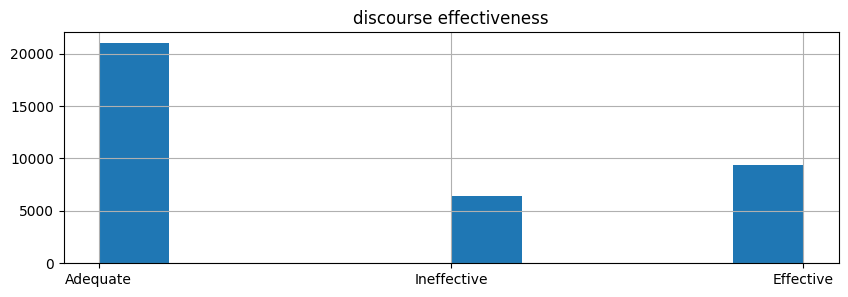

In [5]:
plt.figure(figsize=(10,3))
df['discourse_effectiveness'].hist()
plt.title("discourse effectiveness")
plt.show()

In [6]:
df['discourse_effectiveness'].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [7]:
df['discourse_effectiveness'].isna().any()

False

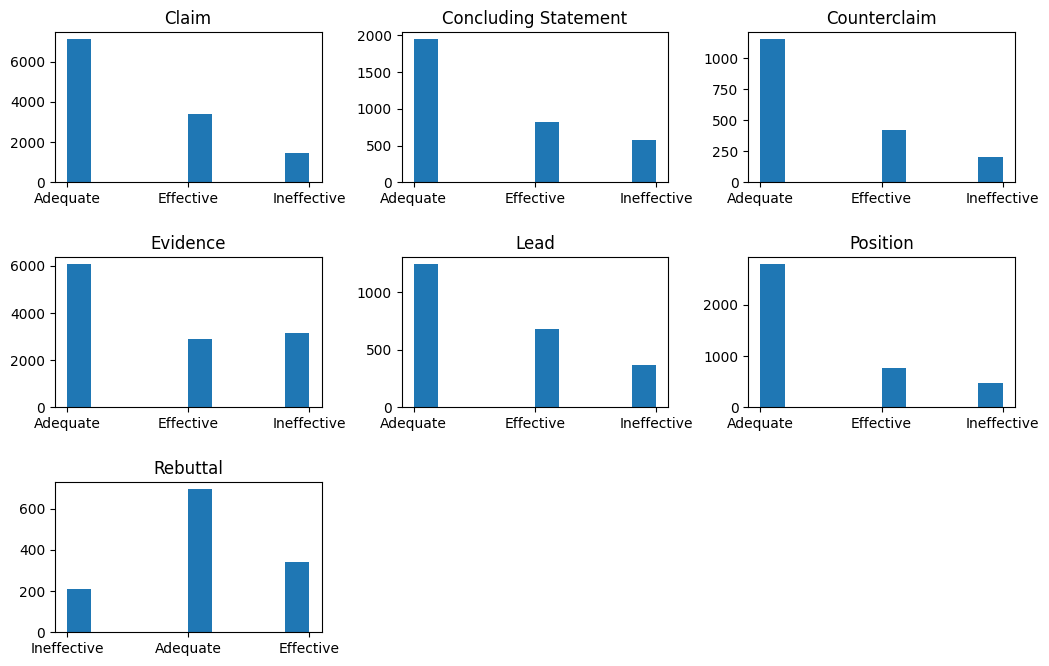

In [8]:
df.hist(column='discourse_effectiveness', by='discourse_type', figsize=(12,8), xrot=0)
plt.show()

# Analyze features

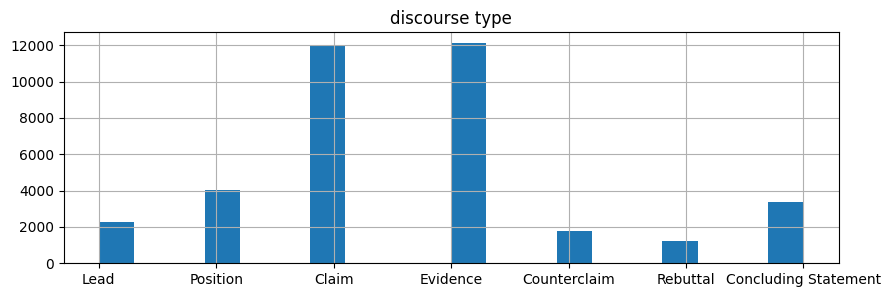

In [9]:
plt.figure(figsize=(10,3))
df['discourse_type'].hist(bins=20)
plt.title("discourse type")
plt.show()

In [10]:
df['discourse_type'].isna().any()

False

In [11]:
df['discourse_text'].isna().any()

False

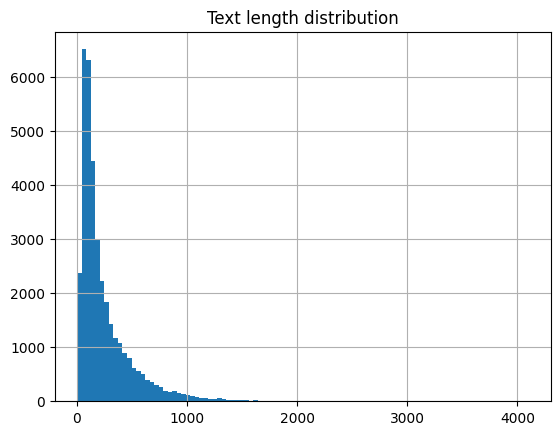

In [12]:
text_lengths = df['discourse_text'].apply(lambda x: len(x))
text_lengths.hist(bins=100)
plt.title("Text length distribution")
plt.show()

In [13]:
words = Counter()
for text in df['discourse_text']:
    words.update(text.lower().split()) 

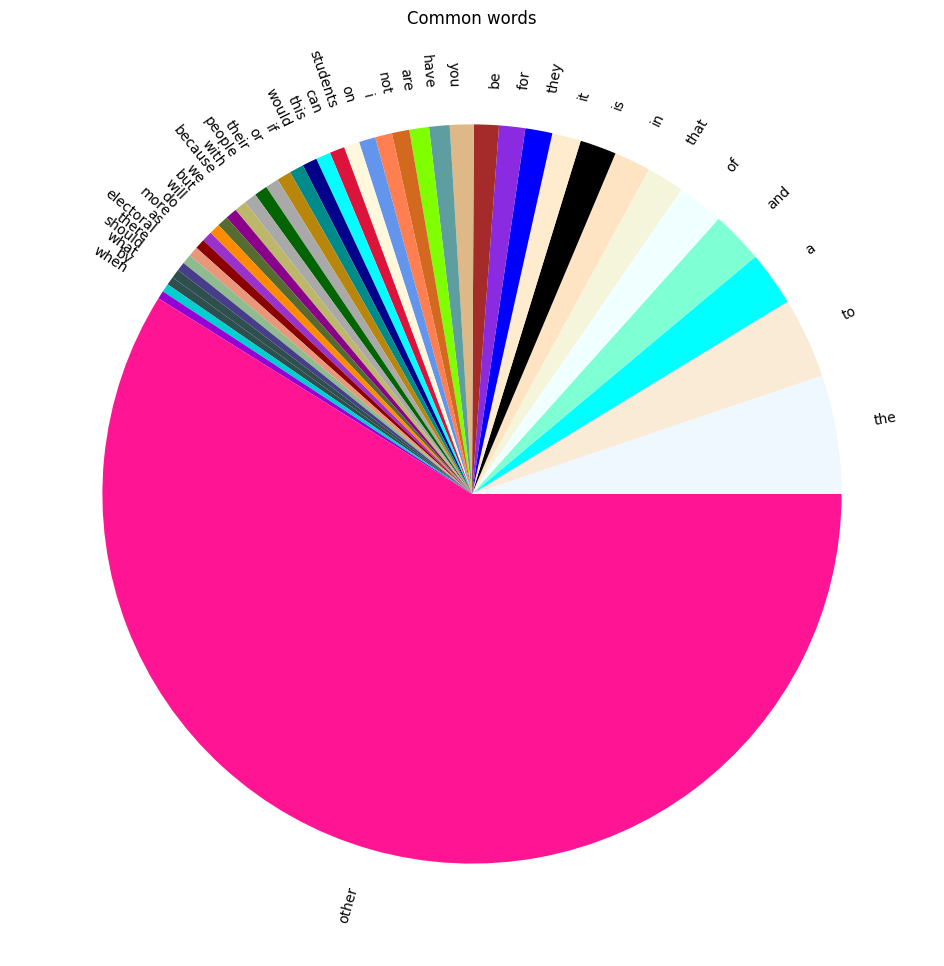

In [14]:
num_words_to_plot = 40
plt.figure(figsize=(12,12))
common_words = words.most_common()
top_words = common_words[:num_words_to_plot] + [['other', str(sum([int(count) for _, count in common_words[num_words_to_plot:]]))]]
top_words = np.array(top_words)

plt.pie(top_words[:, 1], labels =top_words[:, 0], rotatelabels=30, labeldistance=1.1, colors=list(mcolors.CSS4_COLORS.keys()))
plt.title("Common words")
plt.show()

In [15]:
def is_english(s):
    s = s.replace(u'\xa0', u' ')
    return  s.isascii()

texts_with_non_english = []
for text in df['discourse_text']:
    if not is_english(text):
        texts_with_non_english.append(text)

In [16]:
percent_with_non_english = len(texts_with_non_english) / len(df['discourse_text']) * 100
print(f"{percent_with_non_english:.2f}% of texts are with non english chars")

0.29% of texts are with non english chars


In [17]:
num_sentences = []

for text in df['discourse_text']:
    sentences = re.split(r'[.!?]+', text)
    num_sentences.append(len([s for s in sentences if s != ""]))

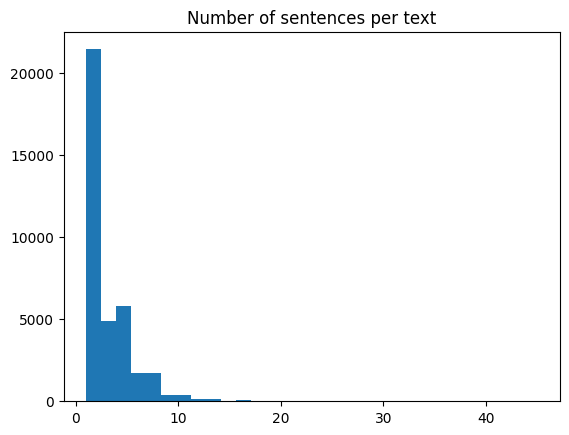

In [18]:
plt.hist(num_sentences, bins=30)
plt.title("Number of sentences per text")
plt.show()

# Modelling

In [7]:
df_shuffled = df.sample(len(df), random_state=RANDOM_STATE) 
 
num_train_samples =  int(len(df_shuffled)*TRAIN_SIZE)
train_data = df_shuffled[:num_train_samples]
test_data = df_shuffled[num_train_samples:]


In [8]:
label2id = {
    'Ineffective' : 2,
    'Effective' : 1,
    'Adequate' : 0
}
id2label = {
    id : label for label, id  in label2id.items()
}

def compute_score(y_true, y_pred):
    scores = f1_score(y_true, y_pred, average=None)
    for i, score in enumerate(scores):
        print(f"f-score for class '{id2label[i]}' = {score:.4f}")

## First automl model

In [105]:
task = Task('multiclass', metric='auc')

roles = {'target': TARGET_NAME, 
         'text': ['discourse_text'],
        'drop': ['discourse_id', 'essay_id', 'discourse_type']}

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    }

)

In [106]:
oof_pred = automl.fit_predict(train_data, roles = roles, verbose=2)

[13:10:49] Stdout logging level is INFO2.
[13:10:49] Task: multiclass

[13:10:49] Start automl preset with listed constraints:
[13:10:49] - time: 3600.00 seconds
[13:10:49] - CPU: 1 cores
[13:10:49] - memory: 16 GB

[13:10:49] Train data shape: (29412, 5)

[13:10:49] Layer 1 train process start. Time left 3599.98 secs
[13:10:49] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[13:10:49] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:08<00:00, 36.20it/s]


[13:13:48] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:08<00:00, 35.86it/s]


[13:16:47] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:08<00:00, 35.86it/s]


[13:19:45] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.7405885965383324
[13:19:45] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[13:19:45] Time left 3064.05 secs

[13:19:45] Layer 1 training completed.

[13:19:45] Automl preset training completed in 535.95 seconds

[13:19:45] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 



In [108]:
compute_score(oof_pred.target, oof_pred.data.argmax(axis=-1))

f-score for class 'Adequate' = 0.7336
f-score for class 'Effective' = 0.6213
f-score for class 'Ineffective' = 0.0000


In [109]:
test_pred = automl.predict(test_data)
true_test = test_data['discourse_effectiveness'].map(lambda x: label2id[x]).tolist()
compute_score(true_test, test_pred.data.argmax(axis=-1))

test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 36.01it/s]


f-score for class 'Adequate' = 0.7360
f-score for class 'Effective' = 0.6379
f-score for class 'Ineffective' = 0.0000


## Second automl model

In [12]:
task = Task('multiclass', metric='auc')

roles = {'target': TARGET_NAME, 
         'text': ['discourse_text'],
        'drop': ['discourse_id', 'essay_id', 'discourse_type']}

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']],
        'n_folds': 3
    },
    reader_params={
        'cv': 3
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'bert-base-uncased'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    },
)

In [13]:
oof_pred = automl.fit_predict(train_data, roles = roles, verbose=2)

[13:22:28] Stdout logging level is INFO2.
[13:22:28] Task: multiclass

[13:22:28] Start automl preset with listed constraints:
[13:22:28] - time: 3600.00 seconds
[13:22:28] - CPU: 1 cores
[13:22:28] - memory: 16 GB

[13:22:28] Train data shape: (29412, 5)

[13:22:28] Layer 1 train process start. Time left 3599.98 secs
[13:22:28] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[13:22:28] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:42<00:00,  7.18it/s]


[13:34:46] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:42<00:00,  7.15it/s]


[13:44:13] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN =====


val: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:42<00:00,  7.17it/s]


[13:56:35] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.7663893152878564
[13:56:35] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[13:56:35] Time left 1553.14 secs

[13:56:35] Layer 1 training completed.

[13:56:35] Automl preset training completed in 2046.86 seconds

[13:56:35] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 



In [14]:
compute_score(oof_pred.target, oof_pred.data.argmax(axis=-1))

f-score for class 'Adequate' = 0.7413
f-score for class 'Effective' = 0.6606
f-score for class 'Ineffective' = 0.0000


In [15]:
test_pred = automl.predict(test_data)
true_test = test_data['discourse_effectiveness'].map(lambda x: label2id[x]).tolist()
compute_score(true_test, test_pred.data.argmax(axis=-1))

test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:32<00:00,  7.16it/s]


f-score for class 'Adequate' = 0.7472
f-score for class 'Effective' = 0.6792
f-score for class 'Ineffective' = 0.0000
